<a href="https://colab.research.google.com/github/byeungchun/cbspeech_topicmodelling/blob/main/topicmodelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Code example: Large language models: a primer for economists

The data processing pipeline transforms raw text into meaningful clusters and topics for analysis. It includes:

- <b>Segmentation</b>: Dividing 10 Wikipedia pages into smaller, manageable chunks.

- <b>Tokenization</b>: Converting text into tokens for each chunk.

- <b>Embedding Transformation</b>: Mapping each chunk into numerical vectors (embeddings) to capture semantic meaning.

- <b>Clustering and Topic Extraction</b>: Grouping embeddings to identify thematic clusters, with topics based on frequently co-occurring terms.

## Setup

In [1]:
# pip install bertopic
!pip install bertopic accelerate --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.7/143.7 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.6 MB/s eta 0:00:00


In [2]:
import re
import json
import requests
import pandas as pd
import numpy as np
import torch

from tqdm import tqdm
from bertopic import BERTopic
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer

from transformers import AutoTokenizer, AutoModel, BitsAndBytesConfig
from gensim import corpora
from gensim.models.ldamodel import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired

pd.set_option('display.max_colwidth', 1000)  # Display full content of columns


### Topic Modeling Parameters

- **arxiv_jsonfile**: URL to the JSON file containing 1000 Genomics reseach paper title and summary in Archive site. This file is hosted on GitHub and will be used as input for topic modeling.
  
- **word_chunk_size**: Defines the size of word chunks to be used in the topic model. Smaller values may capture more fine-grained themes, while larger values may generalize more.

- **bertopic_nr_topics**: Specifies the number of topics to generate in BERTopic modeling. This parameter controls the level of granularity in the topic clusters.

- **embeddingmodel**: Specifies the Hugging Face embedding model to be used for text representations. `'microsoft/Phi-3-mini-4k-instruct'` is a pre-trained model suitable for NLP tasks, but feel free to replace this with any other 'text generation' model available on Hugging Face.


In [3]:
arxiv_jsonfile = r'https://github.com/byeungchun/cbspeech_topicmodelling/blob/main/arxiv.json?raw=true'
word_chunk_size = 100
bertopic_nr_topics = 7
embeddingmodel = 'microsoft/Phi-3-mini-4k-instruct'


## Data Loading
10 Wikipedia pages

In [39]:
# Fetch the data from the URL
response = requests.get(arxiv_jsonfile)
response.raise_for_status()  # Raise an exception for bad status codes

# Load the JSON data
data = json.loads(response.text)
dfarxiv = pd.DataFrame(data)

In [40]:
dfarxiv.head()

,year,title,summary
0,1996,A Growth model for DNA evolution,A simple growth model for DNA evolution is introduced which is analytically\nsolvable and reproduces the observed statistical behavior of real sequences.\n
1,2000,Symmetry Analysis Of Genetic Code And Determinative Degree (in Russian),"A three-dimensional model of the genetic vocabulary is proposed in terms of\ndeterminative degree, an introduced characteristic of nucleotide, which\nreflects absolute difference between purin and pyrimidin bases in one DNA\nstrand. In the fremework of this model manifest symmetry and group properties\nare described. It is proposed to use the determinative degree of codons to\nanalyze genetic texts, and to explain the biological sense of various\nfunctional regions of DNA.\n"
2,2001,Self-organizing Approach for Automated Gene Identification in Whole\n Genomes,An approach based on using the idea of distinguished coding phase in explicit\nform for identification of protein-coding regions (exons) in whole genome has\nbeen proposed. For several genomes an optimal window length for averaging\nGC-content function and calculating codon frequencies has been found.\nSelf-training procedure based on clustering in multidimensional space of\ntriplet frequencies is proposed. For visualization of data in the space of\ntriplet requiencies method of elastic maps was applied.\n
3,2002,On the Hypercube Structure of the Genetic Code,"A representation of the genetic code as a six-dimensional Boolean hypercube\nis proposed. It is assumed here that this structure is the result of the\nhierarchical order of the interaction energies of the bases in codon-anticodon\nrecognition. The proposed structure demonstrates that in the genetic code there\nis a balance between conservatism and innovation. Comparing aligned positions\nin homologous protein sequences two different behaviors are found: a) There are\nsites in which the different amino acids present may be explained by one or two\n""attractor nodes"" (coding for the dominating amino acid(s)) and their one-bit\nneighbors in the codon hypercube, and b) There are sites in which the amino\nacids present correspond to codons located in closed paths in the hypercube.\nThe structure of the code facilitates evolution: the variation found at the\nvariable positions of proteins do not corresponds to random jumps at the codon\nlevel, but to well defined regions of the hypercub..."
4,2002,"Entropy, Transinformation and Word Distribution of Information-Carrying\n Sequences","We investigate correlations in information carriers, e.g. texts and pieces of\nmusic, which are represented by strings of letters. For information carrying\nstrings generated by one source (i.e. a novel or a piece of music) we find\ncorrelations on many length scales. The word distribution, the higher order\nentropies and the transinformation are calculated. The analogy to strings\ngenerated through symbolic dynamics by nonlinear systems in critical states is\ndiscussed.\n"


## Data Processing
- **Chunking:** Split each Wikipedia page into chunks of 100 words each.
- **Embedding Generation:** Create an embedding array for each chunk.

### Chunking

In [6]:
# Preprocess document content and generate text chunks for analysis
# - docs: List to store unique text chunks extracted from the documents
# - df_docs_mapper: List to map the original text ID to generated document chunks
# - docs_cnt: Counter to assign unique IDs to document chunks

# Initialize variables for document processing
docs = []
df_docs_mapper = []
docs_cnt = 0

# Iterate through each record in the DataFrame and generate text chunks
for i, rec in tqdm(dfarxiv.iterrows(), total=len(dfarxiv)):
    text = rec['summary']
    text2 = re.sub(r'[\.\n]', ' ', text)  # Replace periods and newlines with space
    text2 = re.sub(r'\s+', ' ', text2)  # Replace multiple spaces with a single space
    text2 = re.sub(r'[^a-zA-Z0-9 ]', '', text2).strip()  # Remove non-alphanumeric characters
    words = text2.split()

    # Create word chunks from the cleaned text
    word_idx = 0
    while word_idx < len(words):
        word_piece = words[word_idx: word_idx + word_chunk_size]
        is_piece_chunksize = len(word_piece) == word_chunk_size
        chunk_text = ' '.join(word_piece)

        # Add unique chunks to docs and update the document mapper
        if is_piece_chunksize and chunk_text not in docs:
            docs.append(chunk_text)
            df_docs_mapper.append((i, docs_cnt))
            docs_cnt += 1
        word_idx = word_idx + word_chunk_size

# Convert document mapper list to DataFrame and merge with document chunks
df_docs_mapper = pd.DataFrame(df_docs_mapper, columns=['text_id', 'doc_id'])
df_docs = df_docs_mapper.merge(pd.DataFrame(docs), left_index=True, right_index=True)

100%|██████████| 1000/1000 [00:00<00:00, 5034.24it/s]


In [7]:
print(f'Total number of pages: {len(df_docs_mapper.text_id.drop_duplicates())}, total number of chunks (each chunk contains {word_chunk_size} words): {len(docs)}')


Total number of pages: 847, total number of chunks (each chunk contains 100 words): 1179


In [8]:
chunk_stat = df_docs_mapper.groupby('text_id').count().describe()
print(f'For each page, the average number of chunks is: {chunk_stat.iloc[1,0]:.2f}, with a minimum of {chunk_stat.iloc[3,0]} chunks and a maximum of {chunk_stat.iloc[7,0]} chunks.')


For each page, the average number of chunks is: 1.39, with a minimum of 1.0 chunks and a maximum of 3.0 chunks.


In [9]:
# Merge document chunks with mapper and publication dates
# - df_docs: DataFrame that contains document chunks, their corresponding IDs, and publication dates

# Merge document chunks with document mapper DataFrame
df_docs = df_docs_mapper.merge(pd.DataFrame(docs), how='inner', left_on='doc_id', right_index=True)
df_docs.columns = ['text_id', 'doc_id', 'chunk']

### Embedding

#### Embedding Generation Process

- **Purpose**: Generate sentence embeddings using a pre-trained language model.
- **get_sentence_embedding**: A function that generates the embedding for a given sentence using a tokenizer and model.
- **embeddings**: A list to store the embeddings for all documents in the dataset.
- **CPU vs. GPU**:
  - If the code is executed on a **CPU**, it loads precomputed embeddings from a JSON file hosted on GitHub because CPU performance is slower for embedding generation, making real-time processing inefficient.
  - If on **GPU**, it calculates embeddings in real-time using the specified model and tokenizer.

- **get_sentence_embedding Function**:
  - Takes a sentence as input, tokenizes it, and passes it through the model.
  - Extracts the last hidden state and computes the mean to produce the sentence embedding.

- **Final Step**: Converts the embeddings list into a numpy array for further processing.


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if device.type == 'cpu':
  import io
  npzfileurl = 'https://github.com/byeungchun/cbspeech_topicmodelling/blob/main/embeddings_arxiv_msphi3.npz?raw=true'
  response = requests.get(npzfileurl)
  response.raise_for_status()  # Check for errors
  with np.load(io.BytesIO(response.content)) as data:
    embeddings = data['array']
else:
  llm_engine = AutoModel.from_pretrained(
      embeddingmodel,
      device_map= 'auto',
      torch_dtype=torch.float16,
  ).to(device)
  tokenizer = AutoTokenizer.from_pretrained(embeddingmodel)

  def get_sentence_embedding(sentence):
      inputs = tokenizer(sentence, return_tensors='pt').to(device)
      with torch.no_grad():
          outputs = llm_engine(**inputs)
      last_hidden_state = outputs.last_hidden_state
      sentence_embedding = torch.mean(last_hidden_state, dim=1).squeeze().tolist()
      return sentence_embedding

  embeddings = [get_sentence_embedding(doc) for doc in tqdm(docs)]
  embeddings = np.array(embeddings)

config.json:   0%|          | 0.00/967 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/16.5k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/3.44k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.94M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/306 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/599 [00:00<?, ?B/s]

100%|██████████| 1179/1179 [01:30<00:00, 13.02it/s]


In [14]:
# (Optional) save embeddings to npz file
# np.savez_compressed('embeddings_arxiv_msphi3.npz', array=embeddings)

## Topic Modeling

BERTopic model to identify key themes in the dataset. Key parameters include:

- **Top Words (`num_top_words`):** Number of key terms per topic.
- **KeyBERT Words (`num_keybert_words`):** Words representing each topic using KeyBERT.
- **Topic Limit (`topic_limit`):** Maximum number of topics.



In [16]:
num_top_words = 30
num_keybert_words = 10
topic_limit = 20
min_cluster_size = 10
n_gram_range = (1, 3)

representation_model = {"KeyBERT": KeyBERTInspired(top_n_words=num_keybert_words, nr_repr_docs=20)}
vectorizer_model = CountVectorizer(stop_words="english")

# Step 1 - Extract embeddings
embedding_model = 'sentence-transformers/all-MiniLM-L6-v2'

# Step 2 - Reduce dimensionality
umap_model = UMAP(n_neighbors=5,  # Neighboring sample points (Increasing means more global view)
                  n_components=10, # Reduced dimensions of the embeddings
                  min_dist=0.0,
                  metric='euclidean')

# Step 3 - Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=min_cluster_size,
                        metric='euclidean',
                        cluster_selection_method='eom',
                        prediction_data=True)

# Step 4 - Tokenize topics
vectorizer_model = CountVectorizer(stop_words="english",  # Removes stopwords
                                    ngram_range=n_gram_range)  # No. of words in a topic

# Step 5 - Create topic representation
ctfidf_model = ClassTfidfTransformer()

# Step 6 - (Optional) Fine-tune topic representations with
# a `bertopic.representation` model
representation_model = {
  "KeyBERT": KeyBERTInspired(
    top_n_words=15,  # The top n words to extract per topic (default 10)
    nr_repr_docs=12,  # The number of representative documents to extract per cluster (default 5)
    nr_samples=300  # The number of candidate documents to extract per cluster (default 500)
  )
}

# All steps together
topic_model = BERTopic(
  embedding_model=embedding_model,          # Step 1 - Extract embeddings
  umap_model=umap_model,                    # Step 2 - Reduce dimensionality
  hdbscan_model=hdbscan_model,              # Step 3 - Cluster reduced embeddings
  vectorizer_model=vectorizer_model,        # Step 4 - Tokenize topics
  ctfidf_model=ctfidf_model,                # Step 5 - Extract topic words
  representation_model=representation_model, # Step 6 - (Optional) Fine-tune topic representations
  n_gram_range=n_gram_range                 # No. of words per topic
)
# Fit and transform the model on the documents and embeddings
topics, initial_probabilities = topic_model.fit_transform(docs, embeddings)

# Create a DataFrame with the topics and their corresponding probabilities
df_results = pd.DataFrame({'Topic': topics, 'Probability': initial_probabilities})

# Get detailed topic information from the BERTopic model and merge with the results DataFrame
df_topic_info = topic_model.get_topic_info()
df_results = df_results.merge(df_topic_info, how='left', on='Topic')

# Merge document mapper with results DataFrame and filter out documents without topics
embedding_list = [list(val) for val in embeddings]
df_results = df_docs_mapper.merge(df_results, how='left', left_on='doc_id', right_index=True)
df_bertopic_results = df_results[df_results.Topic != -1.0].dropna(how='any').reset_index(drop=True)

In [17]:
df_results['KeyBERT'] = df_results['KeyBERT'].apply(tuple)
topic_keybert_counts = df_results.groupby(['Topic', 'KeyBERT']).size().reset_index(name='counts')
topic_keybert_counts

,Topic,KeyBERT,counts
0,-1,"(genome, genomes, genomic, genes, sequencing, gene, gene expression, rna, transcription, dna, genetic, sequences, evolutionary, nucleotide, sequence)",235
1,0,"(sequencing technologies, sequencing data, genome assembly, reference genome, generation sequencing, genome, genomes, sequencing, genomic, short reads, long reads, novo assembly, dna, reads, sequence)",151
2,1,"(genomewide association studies, association studies gwas, genomewide association, genetic variants, studies gwas, phenotypes, traits, trait, gwas, genetic, genetic variation, genes, genomic, gene, genomewide)",119
3,2,"(dna sequences, genome, genomes, alignment algorithms, protein embedding, proteins, sequences, protein function, gene, alignment, dna, sequence, protein, algorithms, algorithm)",58
4,3,"(transcriptional regulation, transcription factors, gene regulatory, transcription factor, gene expression, transcriptional, genes, transcription, genome, gene, genomes, regulatory elements, rna, rnas, genomic)",56
5,4,"(cancer genome, mutational clustering, somatic mutations, somatic mutation, mutations, driver mutations, multiple cancer types, mutation, cancers, cancer types, gene sets, multiple cancer, driver gene sets, genome, clusters proteins)",46
6,5,"(human genome, genes, genome, genomic, genomes, mutations, evolutionary, mutation rate, beneficial mutations, mutation, evolution, mutational, natural selection, gene, transcriptomes)",45
7,6,"(genome, genes, genomes, wolbachia genes, crop accessions, gene, drosophila, genetic, species, chromosome, chromosomes, plants, strains, aphid, mustard aphid)",37
8,7,"(metagenomic sequencing, metagenomic data, microbial communities, microbiomes, microbiome, metagenomic, bacteriophages, pathogens, bacterial, microbial, bacteria, genomes, genome, strains, phylogenetic)",32
9,8,"(proteomics analysis, proteomics, gel electrophoresis, proteomics longer, analysis proteins, protein detection, electrophoresis, proteomic, word proteomics, twodimensional electrophoresis, protein identification, membrane proteins, protein solubility, proteins, sds electrophoresis)",29


### (Option) LDA Topic Modeling

This optional step applies LDA to identify topics across document chunks. While human labeling was used for topic identification in the main analysis, LDA provides a complementary, automated approach to confirm and explore additional themes. Key parameters and components include:

- **LDA Topic Results (`lda_topic_results`):** Stores LDA topic modeling outcomes for each document set.
- **Topics to Extract (`num_topics_to_extract`):** Specifies the number of topics to identify in each LDA model.

In [18]:
lda_topic_results = []
num_topics_to_extract = 5

# Prepare the documents and dictionary for LDA modeling
document_texts = df_bertopic_results.KeyBERT.to_list()
doc_dictionary = corpora.Dictionary(document_texts)
bow_corpus = [doc_dictionary.doc2bow(doc) for doc in document_texts]

# Train the LDA model with the specified number of topics
lda_model = LdaModel(corpus=bow_corpus, id2word=doc_dictionary, num_topics=num_topics_to_extract, passes=10)

# Extract topics for each document and store the results
document_topic_info = []
for idx, doc_bow in enumerate(bow_corpus):
    doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0.0)
    doc_topics = sorted(doc_topics, key=lambda x: x[1], reverse=True)
    dominant_topic = doc_topics[0][0]
    document_topic_info.append({
        'lda_topic': dominant_topic,
        'lda_probability': doc_topics[0][1],
        'lda_words': ' '.join([x[0] for x in sorted(lda_model.show_topic(dominant_topic), reverse=False)])
    })
lda_topic_results.extend(document_topic_info)

# Print summary of LDA modeling results
print(f'The LDA model was trained with {num_topics_to_extract} topics.')


The LDA model was trained with 5 topics.


In [19]:
lda_topic_results = pd.DataFrame(document_topic_info)

# Print summary of LDA modeling results
print(f'The LDA model was trained with {num_topics_to_extract} topics. The number of documents processed is {len(lda_topic_results)}.')

# Merge BERTopic results and LDA topic results into a single DataFrame
merged_results = df_bertopic_results.merge(lda_topic_results, how='left', left_index=True, right_index=True)

The LDA model was trained with 5 topics. The number of documents processed is 944.


In [20]:
merged_results[['lda_topic','lda_words']].drop_duplicates()

,lda_topic,lda_words
0,2,cancer types evolution gene gene sets genes genome genomes genomic mutation mutations
1,1,dna genome genome assembly genomes genomic long reads reads reference genome sequence sequencing
7,4,gene genes genome genomes genomic strains transcription transcription factor transcription factors transcriptional
29,0,differentially expressed genes expressed genes gene expression genomewide genomic microarray microarray data rnaseq transcriptome transcriptomics
48,3,association studies gwas gene genetic genomewide genomewide association genomic gwas studies gwas trait traits


In [23]:
# ChatGPT or Human labelling using LDA result

topiclists = [
    {'lda_topic': 2, 'topic': 'Cancer Gene Evolution'},
    {'lda_topic': 1, 'topic': 'Genome Sequencing Advances'},
    {'lda_topic': 4, 'topic': 'Transcriptional Genomic Insights'},
    {'lda_topic': 0, 'topic': 'Gene Expression Analysis'},
    {'lda_topic': 3, 'topic': 'Genetic Association Traits'}
]

dftopiclists = pd.DataFrame(topiclists)
merged_results = merged_results.merge(dftopiclists, how='left', on='lda_topic')

#### Sentiment Analysis

In [31]:
merged_results.head(1)

,text_id,doc_id,Topic,Probability,Count,Name,Representation,KeyBERT,Representative_Docs,lda_topic,lda_probability,lda_words,topic
0,3,0,21,0.75596,18,21_length_genomes_law_random,"[length, genomes, law, random, words, distribution, dna, genome, microbial genomes, fitted]","[genomes, typical microbial genomes, genome, genomes grew, genomes reveals, microbial genomes, genomic, genetic code, sequence length, dna words, codon distribution, definition dna words, dna, grows random segmental, dna bases]","[a genomic or proteomic context is different from other definitions such as overrepresented kmers which are much shorter in length Although an approximate powerlaw distribution of protein domain sizes due to gene duplication and the related Zipfs law is well known their translation to the Heaps law in DNA words is not automatic Several other animal genomes are shown herein also to exhibit rangelimited Heaps law with our definition of DNA words though with various exponents When tokens were randomly sampled and sample sizes reach to the maximum level a deviation from the Heaps law was observed but a quadratic, see are remnants of those of their ancestral genomes which were much shorter than the genomes are now This interpretation suggests a simple biologically plausible model for the growth of genomes the genome first grows randomly to an initial length of approximately one thousand nucleotides 1k nt or about one thousandth of its final length thereafter mainly grows by random segme...",2,0.949595,cancer types evolution gene gene sets genes genome genomes genomic mutation mutations,Cancer Gene Evolution


In [42]:
dfdocs = pd.DataFrame(docs, columns=['doc'])

dfdocs = merged_results[['text_id','doc_id','Topic','lda_topic','topic']].merge(dfdocs, left_on='doc_id', right_index=True)

dfdocs = dfdocs.merge(dfarxiv['year'], left_on='text_id', right_index=True)

In [43]:
# LLM request. Here, it assign sentiments randomly
sentiments = ['positive','negative','neutral']
dfdocs['sentiment'] = np.random.choice(sentiments, len(dfdocs))
dfdocs.head()

,text_id,doc_id,Topic,lda_topic,topic,doc,year,sentiment
0,3,0,21,2,Cancer Gene Evolution,A representation of the genetic code as a sixdimensional Boolean hypercube is proposed It is assumed here that this structure is the result of the hierarchical order of the interaction energies of the bases in codonanticodon recognition The proposed structure demonstrates that in the genetic code there is a balance between conservatism and innovation Comparing aligned positions in homologous protein sequences two different behaviors are found a There are sites in which the different amino acids present may be explained by one or two attractor nodes coding for the dominating amino acids and their onebit neighbors in the codon hypercube,2002,positive
1,5,1,2,1,Genome Sequencing Advances,We address the problem of the statistical analysis of a time series generated by complex dynamics with a new method the Diffusion Entropy Analysis DEA Fractals bf 9 193 2001 This method is based on the evaluation of the Shannon entropy of the diffusion process generated by the time series imagined as a physical source of fluctuations rather than on the measurement of the variance of this diffusion process as done with the traditional methods We compare the DEA to the traditional methods of scaling detection and we prove that the DEA is the only method that always yields the,2002,positive
2,5,2,2,1,Genome Sequencing Advances,correct scaling value if the scaling condition applies Furthermore DEA detects the real scaling of a time series without requiring any form of detrending We show that the joint use of DEA and variance method allows to assess whether a time series is characterized by Levy or Gauss statistics We apply the DEA to the study of DNA sequences and we prove that their largetime scales are characterized by Levy statistics regardless of whether they are coding or noncoding sequences We show that the DEA is a reliable technique and at the same time we use it to confirm the,2002,neutral
3,6,3,21,2,Cancer Gene Evolution,Textual analysis of typical microbial genomes reveals that they have the statistical characteristics of a DNA sequence of a much shorter length This peculiar property supports an evolutionary model in which a genome evolves by random mutation but primarily grows by random segmental selfcopying That genomes grew mostly by selfcopying is consistent with the observation that repeat sequences in all genomes are widespread and intragenomic and intergenomic homologous genes are preponderance across all life forms The model predicates the coexistence of the two competing modes of evolution the gradual changes of classical Darwinism and the stochastic spurts envisioned in punctuated,2002,neutral
4,9,5,21,2,Cancer Gene Evolution,We show that textual analysis of microbial genomes reveal telling footprints of the early evolution of the genomes The frequencies of word occurrence of random DNA sequences considered as texts in their four nucleotides are expected to obey Poisson distributions It is noticed that for words less than nine letters the average width of the distributions for complete microbial genomes is many times that of a Poisson distribution We interpret this phenomenon as follows the genome is a large system that possesses the statistical characteristics of a much smaller random system and certain textual statistical properties of genomes we now,2003,neutral


#### Time series analysis

In [59]:
dfgdp = pd.read_csv('https://github.com/byeungchun/cbspeech_topicmodelling/blob/main/GDPA.csv?raw=true')
dfgdp['DATE'] = pd.to_datetime(dfgdp['DATE'], format='%Y-%m-%d')
dfgdp.head()

,DATE,GDPA
0,1929-01-01,104.556
1,1930-01-01,92.160
2,1931-01-01,77.391
3,1932-01-01,59.522
4,1933-01-01,57.154


In [55]:
dfsentiment = dfdocs[['year','sentiment']]
dfsentiment['DATE'] = pd.to_datetime(dfsentiment['year'], format='%Y')
dfsentiment = dfsentiment.groupby(['DATE','sentiment']).size().reset_index()
dfsentiment = dfsentiment.pivot(index='DATE', columns='sentiment', values=0).fillna(0).astype(int)
dfsentiment.head()

sentiment,negative,neutral,positive
DATE,,,
2002-01-01,0,2,2
2003-01-01,5,6,6
2004-01-01,10,10,18
2005-01-01,17,7,15
2006-01-01,15,12,13


In [61]:
dfsentgdp = dfsentiment.merge(dfgdp, left_index=True, right_on='DATE')
dfsentgdp = dfsentgdp.set_index('DATE')
dfsentgdp.head()

,negative,neutral,positive,GDPA
DATE,,,,
2002-01-01,0,2,2,10929.108
2003-01-01,5,6,6,11456.450
2004-01-01,10,10,18,12217.196
2005-01-01,17,7,15,13039.197
2006-01-01,15,12,13,13815.583


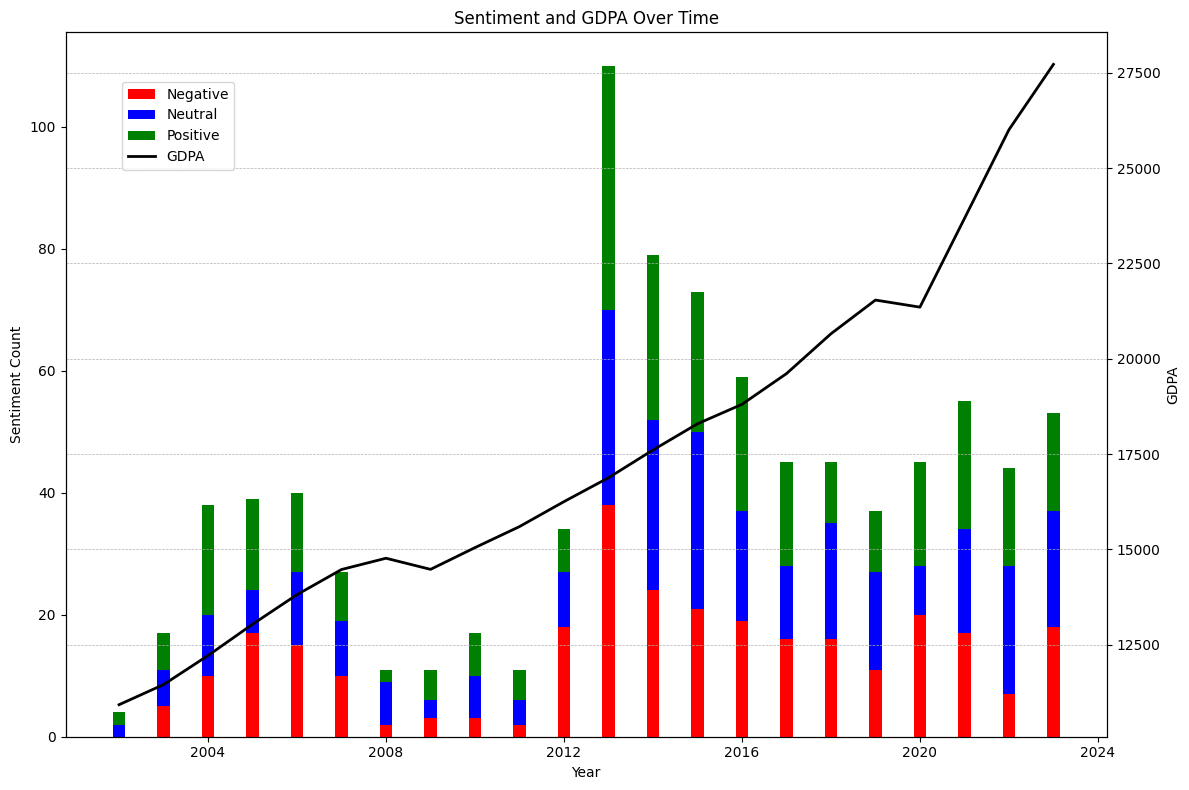

In [73]:
# plot 2 y-axis of dfsentgdp

import matplotlib.pyplot as plt

# Further increasing bar width for better visibility
bar_width = 100  # Adjusted bar width for more thickness

# Plot
fig, ax1 = plt.subplots(figsize=(12, 8))

# Stacked bar chart for sentiments with increased bar width
ax1.bar(dfsentgdp.index, dfsentgdp['negative'], label='Negative', color='red', width=bar_width, align='center')
ax1.bar(dfsentgdp.index, dfsentgdp['neutral'], bottom=dfsentgdp['negative'], label='Neutral', color='blue', width=bar_width, align='center')
ax1.bar(dfsentgdp.index, dfsentgdp['positive'], bottom=dfsentgdp['negative'] + dfsentgdp['neutral'], label='Positive', color='green', width=bar_width, align='center')

# Configure ax1
ax1.set_xlabel('Year')
ax1.set_ylabel('Sentiment Count')
ax1.tick_params(axis='y')
ax1.set_title('Sentiment and GDPA Over Time')

# Line plot for GDPA on secondary axis
ax2 = ax1.twinx()
ax2.plot(dfsentgdp.index, dfsentgdp['GDPA'], label='GDPA', color='black', linewidth=2)
ax2.set_ylabel('GDPA')
ax2.tick_params(axis='y', labelcolor='black')

# Combine legends
fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# Grid and layout
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

